In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

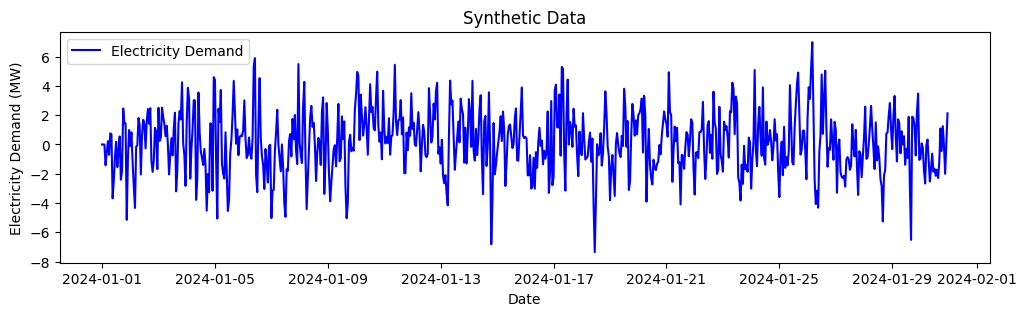

In [2]:
# Generate some data to come from an AR process
np.random.seed(510)
n_hours = 24*30
phi = [0.5, -0.25, 0.1]   # Coefficients for order 3
sigma = 2  # Standard deviation of the noise

# Generate
demand_series = np.zeros(n_hours)
for t in range(3, n_hours):
    demand_series[t] = (phi[0] * demand_series[t-1] +
                        phi[1] * demand_series[t-2] +
                        phi[2] * demand_series[t-3] +
                        np.random.normal(0, sigma))  # Add noise
time_index = pd.date_range(start='2024-01-01', periods=n_hours, freq='h')
demand_series = pd.Series(demand_series, index=time_index)

plt.figure(figsize=(12, 3))
plt.plot(demand_series, label='Electricity Demand', color='blue')
plt.title('Synthetic Data')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()

In [3]:
# Check for stationarity using ADF test
adf_result = adfuller(demand_series)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
# p-value>0.05 would suggest that there is insufficient evidence to conclude that the series is stationary
# our p-value<0.05, so we are all good!

ADF Statistic: -12.621683726926598
p-value: 1.5732133252758353e-23


In [4]:
#If there were issues with stationarity, one could try applying differencing as shown below.
# Remember to then use differentiated data for training the model on and for forecasting!
differenciate = False
if(differenciate):
    # Apply differencing
    differenced_series = demand_series.diff().dropna()
    # Perform ADF test on differenced series
    adf_result_diff = adfuller(differenced_series)
    print(f'ADF Statistic after differencing: {adf_result_diff[0]}')
    print(f'p-value after differencing: {adf_result_diff[1]}')
    # Have a look
    plt.figure(figsize=(12, 6))
    plt.plot(differenced_series.index, differenced_series, label='Differenced Electricity Demand (MW)', color='darkgreen')
    plt.title('Differenced Hourly Electricity Demand')
    plt.xlabel('Date')
    plt.ylabel('Differenced Electricity Demand (MW)')
    plt.legend()
    plt.grid()
    plt.show()

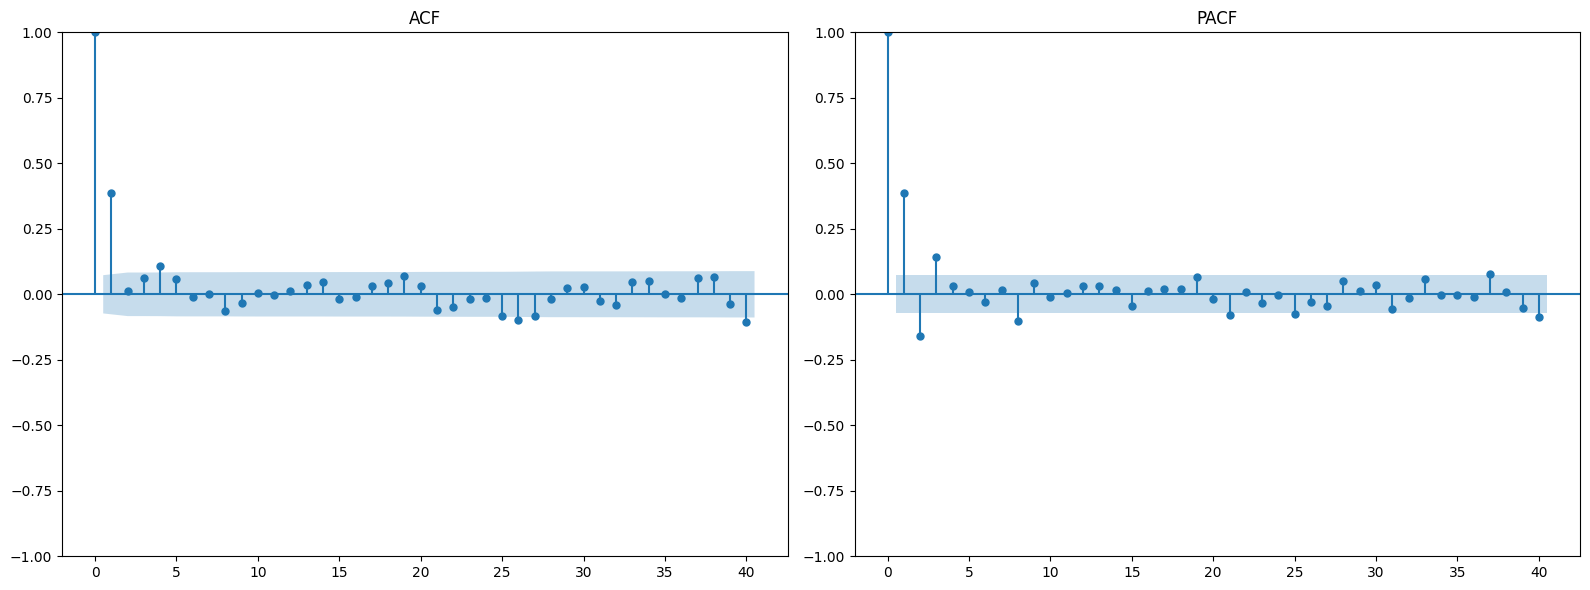

In [5]:
# Let's look at ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# ACF
plot_acf(demand_series, lags=40, ax=axes[0])
axes[0].set_title('ACF')
# PACF
plot_pacf(demand_series, lags=40, ax=axes[1])
axes[1].set_title('PACF')

plt.tight_layout()
plt.show()

# Order 3 looks appropriate here

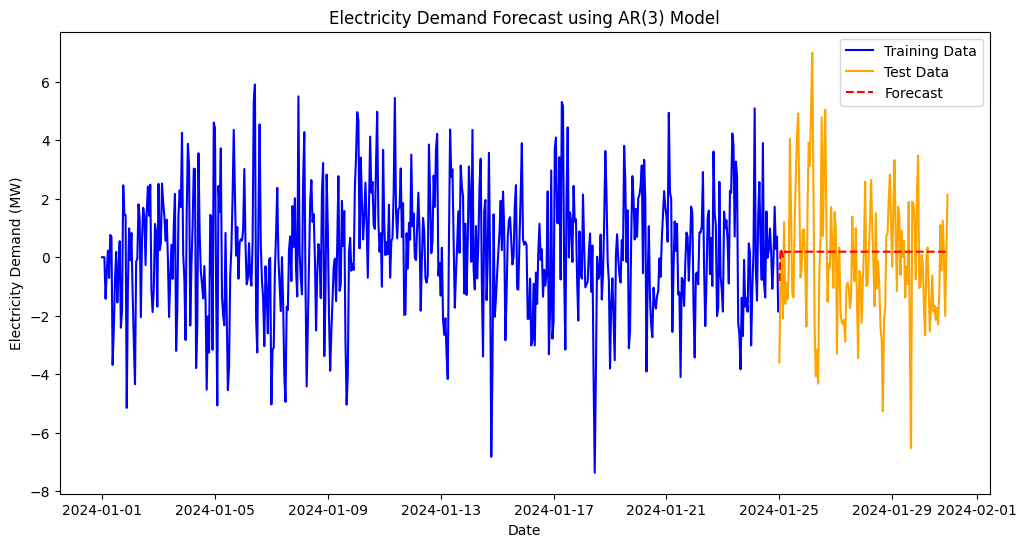

In [6]:
# Split the data into training and test sets
train_size = int(len(demand_series) * 0.8)
train, test = demand_series[:train_size], demand_series[train_size:]

# Fit AR(3)
model = AutoReg(train, lags=3)
model_fit = model.fit()

# Forecast the next values 
n_forecast = len(test)
forecast = model_fit.predict(start=len(train), end=len(train) + n_forecast - 1)
forecast_index = test.index

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('Electricity Demand Forecast using AR(3) Model')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.show()

In [7]:
# How to use AIC and BIC

# Fit AR(3)
model_ar3 = AutoReg(train, lags=3)
model_fit_ar3 = model_ar3.fit()

# Fit AR(1) 
model_ar1 = AutoReg(train, lags=1)
model_fit_ar1 = model_ar1.fit()

# Calculate AIC and BIC 
aic_ar3 = round(model_fit_ar3.aic, 2)
bic_ar3 = round(model_fit_ar3.bic, 2)
aic_ar1 = round(model_fit_ar1.aic, 2)
bic_ar1 = round(model_fit_ar1.bic, 2)

print(f'AR(3) - AIC: {aic_ar3}, BIC: {bic_ar3}')
print(f'AR(1) - AIC: {aic_ar1}, BIC: {bic_ar1}')

AR(3) - AIC: 2386.92, BIC: 2408.68
AR(1) - AIC: 2417.05, BIC: 2430.11


In [8]:
# Forecast on test set
forecast_ar3 = model_fit_ar3.predict(start=len(train), end=len(train) + len(test) - 1)
forecast_ar1 = model_fit_ar1.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate MSE
mse_ar3_manual = np.mean((test - forecast_ar3) ** 2)
mse_ar1_manual = np.mean((test - forecast_ar1) ** 2)

print(f'Mean Squared Error (MSE) for AR(3): {mse_ar3_manual:.5f}')
print(f'Mean Squared Error (MSE) for AR(1): {mse_ar1_manual:.5f}')


Mean Squared Error (MSE) for AR(3): 4.60821
Mean Squared Error (MSE) for AR(1): 4.61841
